In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"
#pre_trained = "smanjil/German-MedBERT"


### Hyperparameters


In [2]:
epochs = 32
batch_size = 30
drop_out = 0.2
learning_rate = 1e-5

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  
dataset['Text'] = dataset['Text'].astype(str)


In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=learning_rate, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.6339124268379763
Validation loss: 1.3999722829231849
F1 Score (Weighted): 0.43100687339556976


Epoch 2:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.3355922172034995
Validation loss: 1.154351193171281
F1 Score (Weighted): 0.5455689862926588


Epoch 3:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0969536943712097
Validation loss: 1.0049836085392878
F1 Score (Weighted): 0.6021662502957905


Epoch 4:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.9534403344859248
Validation loss: 0.9301194548606873
F1 Score (Weighted): 0.6542810022833029


Epoch 5:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.820102548253709
Validation loss: 0.878496371782743
F1 Score (Weighted): 0.6794420998992619


Epoch 6:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.7210140150526295
Validation loss: 0.8594024250140557
F1 Score (Weighted): 0.7095132561710707


Epoch 7:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.6136483537114185
Validation loss: 0.8479543534608988
F1 Score (Weighted): 0.7039574712525862


Epoch 8:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.5477575396282085
Validation loss: 0.8572137745527121
F1 Score (Weighted): 0.728496718687059


Epoch 9:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.48351106825082196
Validation loss: 0.8657723951798219
F1 Score (Weighted): 0.7159983568451881


Epoch 10:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.4243388921022415
Validation loss: 0.8706602190549557
F1 Score (Weighted): 0.7263110464322896


Epoch 11:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.3895084622545519
Validation loss: 0.8941372598593051
F1 Score (Weighted): 0.719110552520015


Epoch 12:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.336789938526741
Validation loss: 0.927035045165282
F1 Score (Weighted): 0.7126156835823633


Epoch 13:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.312982139164123
Validation loss: 0.940623293702419
F1 Score (Weighted): 0.7137907709430424


Epoch 14:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.2879178004636281
Validation loss: 0.9562904662810839
F1 Score (Weighted): 0.7289876220319412


Epoch 15:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.27329618343408557
Validation loss: 0.9617041807908279
F1 Score (Weighted): 0.7235187661711459


Epoch 16:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.2222552845875422
Validation loss: 0.9810176967428281
F1 Score (Weighted): 0.7538768719774852


Epoch 17:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.20875615421412647
Validation loss: 1.0256102990645628
F1 Score (Weighted): 0.7222111434343876


Epoch 18:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.2046063083993352
Validation loss: 1.0624649375677109
F1 Score (Weighted): 0.725931075161216


Epoch 19:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.20241570926230887
Validation loss: 1.0368144219884505
F1 Score (Weighted): 0.7270206323256341


Epoch 20:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.18008881480689498
Validation loss: 1.0813005996438174
F1 Score (Weighted): 0.7292912847075207


Epoch 21:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.1692810946724553
Validation loss: 1.0935542663702598
F1 Score (Weighted): 0.7223790771793993


Epoch 22:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.1585895183455685
Validation loss: 1.1050429590619528
F1 Score (Weighted): 0.7309102577726749


Epoch 23:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.15038951227198477
Validation loss: 1.1179191229435115
F1 Score (Weighted): 0.7341459329255275


Epoch 24:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.16099954898590627
Validation loss: 1.1135860899320016
F1 Score (Weighted): 0.744131815456655


Epoch 25:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.13649049436376579
Validation loss: 1.1345165626933942
F1 Score (Weighted): 0.7302785627958293


Epoch 26:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.12544306513407957
Validation loss: 1.1424492574655092
F1 Score (Weighted): 0.734028433719761


Epoch 27:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.12357781058096368
Validation loss: 1.1481578395916865
F1 Score (Weighted): 0.7358521458535358


Epoch 28:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.1357070546111335
Validation loss: 1.171251499882111
F1 Score (Weighted): 0.7275161366617241


Epoch 29:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.11247805379115153
Validation loss: 1.1748131290078163
F1 Score (Weighted): 0.7298667295063517


Epoch 30:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.11648737420530422
Validation loss: 1.1762890007633429
F1 Score (Weighted): 0.733717001500666


Epoch 31:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.10944201918723791
Validation loss: 1.1846917363313527
F1 Score (Weighted): 0.7303724167470045


Epoch 32:   0%|          | 0/69 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.10313797964835944
Validation loss: 1.1842930087676415
F1 Score (Weighted): 0.7306683889569366


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.43100687339556976), (2, 0.5455689862926588), (3, 0.6021662502957905), (4, 0.6542810022833029), (5, 0.6794420998992619), (6, 0.7095132561710707), (7, 0.7039574712525862), (8, 0.728496718687059), (9, 0.7159983568451881), (10, 0.7263110464322896), (11, 0.719110552520015), (12, 0.7126156835823633), (13, 0.7137907709430424), (14, 0.7289876220319412), (15, 0.7235187661711459), (16, 0.7538768719774852), (17, 0.7222111434343876), (18, 0.725931075161216), (19, 0.7270206323256341), (20, 0.7292912847075207), (21, 0.7223790771793993), (22, 0.7309102577726749), (23, 0.7341459329255275), (24, 0.744131815456655), (25, 0.7302785627958293), (26, 0.734028433719761), (27, 0.7358521458535358), (28, 0.7275161366617241), (29, 0.7298667295063517), (30, 0.733717001500666), (31, 0.7303724167470045), (32, 0.7306683889569366)]


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.36733986925931844, 1), (0.484427843358439, 2), (0.5325276293856028, 3), (0.5812151731403546, 4), (0.6130600149253663, 5), (0.6591750090347636, 6), (0.6563326940503488, 7), (0.6792198798648587, 8), (0.671742299364643, 9), (0.682974634264538, 10), (0.6727110576271361, 11), (0.6596273479711603, 12), (0.6673076291731096, 13), (0.6860042800433616, 14), (0.6720655780105252, 15), (0.7058714577757423, 16), (0.6742943319001774, 17), (0.6729805307337201, 18), (0.6805018483323879, 19), (0.678194387220111, 20), (0.6710677953054255, 21), (0.6820501242357387, 22), (0.6852568987450972, 23), (0.6944287388500002, 24), (0.6806914203000235, 25), (0.6849236874541296, 26), (0.6883901360480146, 27), (0.6782701960180294, 28), (0.6826430096112328, 29), (0.6855165728296236, 30), (0.6824862697993206, 31), (0.6818933844238265, 32)]


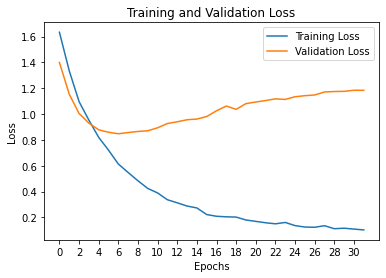

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()